In [1]:
import nibabel as nib
import numpy as np
import torch
import napari
import pandas as pd
import os
import matplotlib.pyplot as plt

c:\Users\vegaarellano\Anaconda3\envs\python-pytorch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
viewer = napari.Viewer()

In [5]:

# Display the original image
files = [
        "../dataset/train/images/sub-r035s014_ses-1_T1w.nii.gz",
        "../dataset/train/masks/sub-r035s014_ses-1_space-orig_label-L_desc-T1lesion_mask.nii.gz"
]
#prediction="predictions/result_1_2022-04-26.nii"
for file in files:
    test_load = nib.load(file)
    #test_load = nib.load(original)
    input_image = test_load.get_fdata() # last dimension is depth
    if "_mask" in file:
        viewer.add_image(np.transpose(input_image, axes=[2,0,1]), name="Mask", blending="additive", colormap="red" )
    else:
        viewer.add_image(np.transpose(input_image, axes=[2,0,1]), name="Original")
    
    input_image = np.transpose(input_image, (0,1,2))

In [93]:
input_image.shape

(192, 512, 512)

In [2]:

# Display the original image
def readOneFile(pathlib):
    test_load = nib.load(pathlib)
    input_image = test_load.get_fdata() # last dimension is depth
    #viewer.add_image(np.transpose(input_image, axes=[2,0,1]), name="Mask")
    input_image = torch.from_numpy(input_image)
    depth = input_image.shape[2]
    file_with_mask = 0
    flag_init = True
    start_index = 0
    end_index = 0
    for i in range(depth):   
        if torch.sum(input_image[:,:,i]) > 0:
            file_with_mask += 1
            #Detect first occurrence in the mask
            if flag_init:
                flag_init = False
                start_index = i
                end_index += start_index
            else:
                end_index += 1
    #image_range = end_index - start_index    
    return file, depth, file_with_mask, start_index, end_index


In [3]:
def removeEmptyData(imgPathLib, maskPathLib):
    """Clean empty sequences of patients """  
    img_temp = nib.load(imgPathLib)
    print(img_temp)
    img = torch.from_numpy(img_temp.get_fdata()) # last dimension is depth    
    mask = torch.from_numpy(nib.load(maskPathLib).get_fdata()) # last dimension is depth
    # print(img.shape)
    # print(mask.shape)
    assert img.shape == mask.shape
    img_temp = []
    mask_temp = []
    depth = input_image.shape[2]
    for i in range(depth):
        # If there is data, we save images and mask
        #print(f"{i} Sum:{torch.sum(img[:,:,i])} Max: {torch.max(img[:,:,i])} Min: {torch.min(img[:,:,i])}")
        if torch.max(img[:,:,i]) > 100:
            img_temp.append(torch.unsqueeze(img[:,:,i],dim=0))
            mask_temp.append(torch.unsqueeze(mask[:,:,i],dim=0))
    #print(img_temp[0].shape)
    final_img = torch.concat(img_temp, dim=0)
    final_mask =  torch.concat(mask_temp,dim=0)
    #print(final_img.shape)
    viewer.add_image(np.transpose(final_img.numpy(), axes=[0,1,2]), name="Img")
    viewer.add_image(np.transpose(final_mask.numpy(), axes=[0,1,2]), name="Mask")
    clipped_img = nib.Nifti1Image(final_img, img_temp.affine, img_temp.header)
    #clipped_img = nib.Nifti1Image(final_img, img.affine, img.header)
    nib.save(clipped_img, imgPathLib.replace(f"{imgPathLib}.nii.gz","v2.nii.gz"))
    #nib.save(final_mask, imgPathLib.replace(f"{maskPathLib}_mask.nii.gz","v2_mask.nii.gz"))
    return 

In [124]:
removeEmptyData(files[0], files[1])

<class 'nibabel.nifti1.Nifti1Image'>
data shape (192, 512, 512)
affine: 
[[-9.99500334e-01 -1.12824254e-02  5.23287803e-03  9.36271286e+01]
 [-2.25596949e-02  4.99872684e-01  1.00249381e-04 -1.01103378e+02]
 [ 1.04656238e-02  1.78562350e-05  4.99972612e-01 -1.37645615e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 192 512 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.9998097  0.5        0.5        0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
c

AttributeError: 'list' object has no attribute 'affine'

PluginError: Error in plugin 'builtins', hook 'napari_get_reader'
  Cause was: ValueError('Could not find a backend to open `C:\\Users\\vegaarellano\\Documents\\Gitlab\\instancesegmentation\\dataset\\test\\images\\sub-r009s001_ses-1_T1w.nii.gz`` with iomode `ri`.')
    in file: c:\Users\vegaarellano\Anaconda3\envs\python-pytorch-gpu\lib\site-packages\imageio\core\imopen.py
    at line: 283
     author: napari team
      email: napari-steering-council@googlegroups.com
    package: napari
        url: https://napari.org
    version: 0.4.12



In [5]:
# Load files from each dataset
folders = ["../dataset/train/images/","../dataset/validation/images/", "../dataset/test/images/"]
for folder in folders:
    #pathlib = "../dataset/train/images/"
    values = []
    for file in os.listdir(folder):
        if ".nii.gz" in file:
            result = readOneFile(f"{folder}{file}")
            values.append(result)
    dataset = folder.split("/")[2]
    df = pd.DataFrame(values, columns=['File','Depth', 'no_masks', 'start_index','end_index'])
    # calculate the image range of the images with masks
    df["image_range"] = df["end_index"] - df["start_index"]
    df["images_with_area"] = df["Depth"] - df["no_masks"]
    df.to_csv(f"../dataProcessing/{dataset}_files.csv")
    print(f"File generated in ../dataProcessing/{dataset}_files.csv")


File generated in ../dataProcessing/train_files.csv
File generated in ../dataProcessing/validation_files.csv
File generated in ../dataProcessing/test_files.csv


In [64]:

#df.head()

,File,Depth,no_masks,start_index,end_index
0,sub-r001s001_ses-1_space-orig_label-L_desc-T1l...,181,77,76,152
1,sub-r001s002_ses-1_space-orig_label-L_desc-T1l...,155,77,26,102
2,sub-r001s003_ses-1_space-orig_label-L_desc-T1l...,197,21,121,141
3,sub-r001s004_ses-1_space-orig_label-L_desc-T1l...,197,76,52,127
4,sub-r001s005_ses-1_space-orig_label-L_desc-T1l...,195,54,100,153


In [65]:
# calculate the image range of the images with masks
df["image_range"] = df["end_index"] - df["start_index"]
df["images_with_area"] = df["Depth"] - df["no_masks"]

In [66]:
df.head()

,File,Depth,no_masks,start_index,end_index,image_range,images_with_area
0,sub-r001s001_ses-1_space-orig_label-L_desc-T1l...,181,77,76,152,76,104
1,sub-r001s002_ses-1_space-orig_label-L_desc-T1l...,155,77,26,102,76,78
2,sub-r001s003_ses-1_space-orig_label-L_desc-T1l...,197,21,121,141,20,176
3,sub-r001s004_ses-1_space-orig_label-L_desc-T1l...,197,76,52,127,75,121
4,sub-r001s005_ses-1_space-orig_label-L_desc-T1l...,195,54,100,153,53,141


In [67]:
df.to_csv("../dataProcessing/training_files.csv")

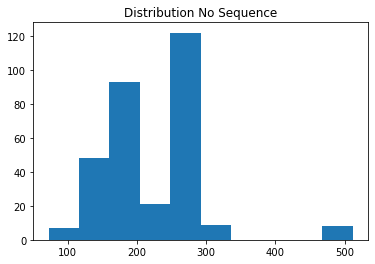

In [68]:
# Plots
plt.hist(df["Depth"])
plt.title("Distribution No Sequence")
plt.show()

In [82]:
print(np.max(df["Depth"]))
print(np.min(df["Depth"]))
print(np.mean(df["Depth"]))
print(np.median(df["Depth"]))

print(df.loc[df["Depth"]==512,"File"])

512
72
221.89285714285714
230.0
228    sub-r035s003_ses-1_space-orig_label-L_desc-T1l...
229    sub-r035s005_ses-1_space-orig_label-L_desc-T1l...
230    sub-r035s006_ses-1_space-orig_label-L_desc-T1l...
231    sub-r035s007_ses-1_space-orig_label-L_desc-T1l...
232    sub-r035s011_ses-1_space-orig_label-L_desc-T1l...
233    sub-r035s012_ses-1_space-orig_label-L_desc-T1l...
234    sub-r035s013_ses-1_space-orig_label-L_desc-T1l...
235    sub-r035s014_ses-1_space-orig_label-L_desc-T1l...
Name: File, dtype: object


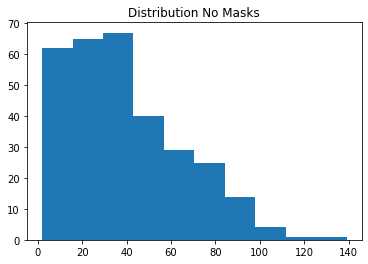

In [69]:
# Plots
plt.hist(df["no_masks"])
plt.title("Distribution No Masks")
plt.show()

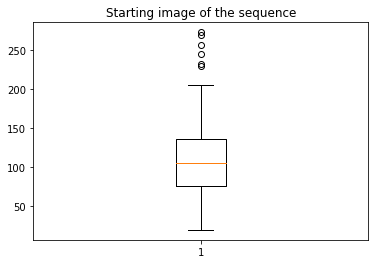

In [70]:
plt.boxplot(df["start_index"])
plt.title("Starting image of the sequence")
plt.show()

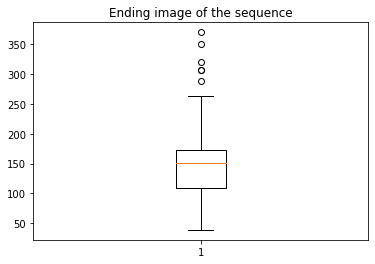

In [71]:
plt.boxplot(df["end_index"])
plt.title("Ending image of the sequence")
plt.show()

In [22]:
# Get 32 multiples 
n = 32
max = 600
for i in range(n,max+1,n):
    print(i)
    

32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576


In [53]:
import torch
sub_x = torch.zeros((1,1,32,128,128))
sub_y = torch.ones((1,1,32,128,128))
predictions = torch.zeros((1,1,32,128,128))


In [57]:
import torchvision
from datetime import date
print(sub_x[:,:,15,:,:].shape)
result = torch.cat((sub_x[:,:,15,:,:],sub_y[:,:,15,:,:],predictions[:,:,15,:,:]),dim=0)
grid = torchvision.utils.make_grid(result, nrow=3, padding=100)
torchvision.utils.save_image(grid, f'./vnet_training_{date.today()}.png')

torch.Size([1, 1, 128, 128])


In [47]:
n = 32
input = 208
result = 0
# print(512/33)
# print(512//33)
# print(512%33)
print(input/n)
print(input//n)
print(input%n)
if input%n > 0:
    result = ((input//n)*n+n) - input
    print("first case")
#print(result)
print(f"Need to create {result} slices")

6.5
6
16
first case
Need to create 16 slices


In [5]:
import torch.nn as nn
import torch


class one_step_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(one_step_conv, self).__init__()
        self.conv = nn.Sequential(
            # Level 1            
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),            
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            # Level 2            
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1),            
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            #nn.Dropout2d(p=0.2)             
        )

    def forward(self, input):
        input = self.conv(input)
        return input


In [6]:
x = torch.rand((1,1,256,256))            
print(x.shape)
model = one_step_conv(in_ch=1, out_ch=1)
pred = model(x)
print(pred.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
